<a href="https://colab.research.google.com/github/adriendod/Color_Classification/blob/master/Color_Classification_CNN_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:

import json
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from tensorboardcolab import *


!nvidia-smi

Mon May 27 15:42:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |   8739MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Data Science/Projets/Car_color_classification/data.zip" -d "/content"

In [58]:

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [0]:
# model config
img_rows , img_cols = 224,224
num_classes = 10
batch_size = 64
nb_epoch = 4
data_directory = "/content/data"
class_list = ['black', 'blue', 'cyan', 'green', 'grey_light', 'grey_other', 'notACar', 'red', 'white', 'yellow']
FC_LAYERS = [1024, 1024]
dropout = 0.5

model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture





In [0]:

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
filepath = 'color_weights.hdf5'
checkpoint = TensorBoardColabCallback(tbc)
callbacks_list = [checkpoint]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        validation_split=0.2)


training_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'training')

test_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'validation')

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())

In [0]:
#Fitting model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(
        training_set,
        steps_per_epoch=500,
        epochs=nb_epoch,
        validation_data=test_set,
        validation_steps=250)

model.save('/content/gdrive/My Drive/Data Science/Projets/Car_color_classification/color_model.h5')
with open('/content/gdrive/My Drive/Data Science/Projets/Car_color_classification/history.json', 'w') as f:
    json.dump(history.history, f)


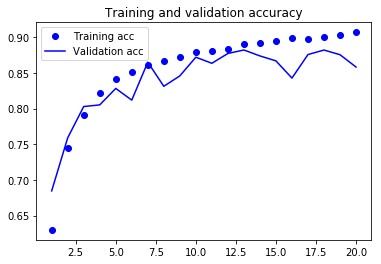

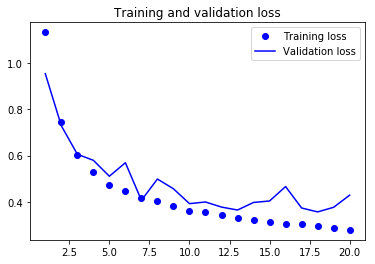

In [0]:
#plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
#Loading model
model = load_model('/content/gdrive/My Drive/Car_color_classification/color_model.h5')


#Confution Matrix and Classification Report

test_set_CM = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            subset = 'validation')

Y_pred = model.predict_generator(test_set_CM, 136)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set_CM.classes, y_pred))
print('Classification Report')
target_names = ['black', 'blue', 'cyan', 'green', 'grey_light', 'grey_other', 'notACar', 'red', 'white', 'yellow']
print(classification_report(test_set_CM.classes, y_pred, target_names=target_names))

Found 8695 images belonging to 10 classes.
Confusion Matrix
[[2453   79    1    1   17  106   77   10   31    0]
 [  32  560    3    2    2    7    2    4    8    1]
 [   0    0   54    0    0    0    0    0    2    0]
 [  21    5    0  104    3    7    8    0    8    2]
 [   5   11    1    0  478   15   14    1  291    1]
 [  55   35    0    1  138  223   15    4   12    1]
 [   2    3    0    1    6    4  388    7   14    0]
 [   3    1    0    1    2    4   21 1202    2    2]
 [   8    2    0    0   25    3   38    4 1812    0]
 [   0    1    0    2    0    1    4    6   24  191]]
Classification Report
              precision    recall  f1-score   support

       black       0.95      0.88      0.92      2775
        blue       0.80      0.90      0.85       621
        cyan       0.92      0.96      0.94        56
       green       0.93      0.66      0.77       158
  grey_light       0.71      0.59      0.64       817
  grey_other       0.60      0.46      0.52       484
     not

Text(0.5, 41.09375, 'Predicted label')

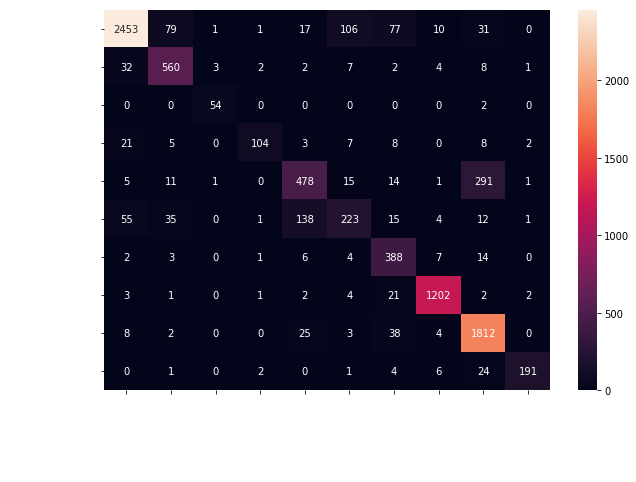

In [0]:
cm = confusion_matrix(test_set_CM.classes, y_pred)

df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

  
fig = plt.figure(figsize = (10,7))
    
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, color="white")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14, color="white")
plt.ylabel('True label', color="white")
plt.xlabel('Predicted label', color="white")


Text(0.5, 41.09375, 'Predicted label')

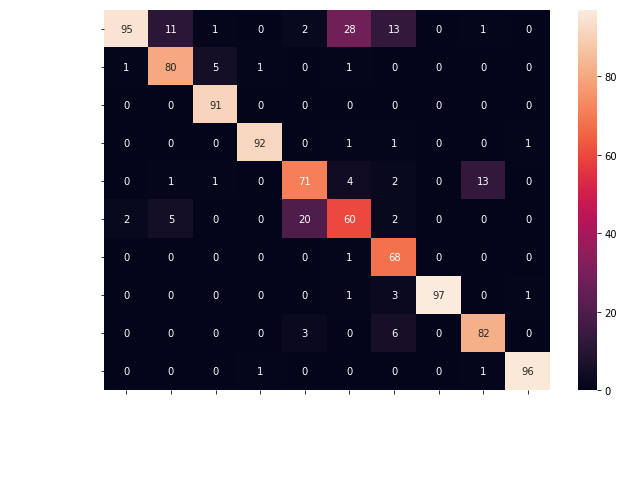

In [0]:
df_cm_percent = df_cm.copy()

for i in df_cm:
  for j in range(0, len(df_cm)):
    df_cm_percent[i][j] = df_cm[i][j] / df_cm[i].sum() * 100
  
fig = plt.figure(figsize = (10,7))
    
heatmap = sns.heatmap(df_cm_percent, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, color="white")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14, color="white")
plt.ylabel('True label', color="white")
plt.xlabel('Predicted label', color="white")


In [0]:
!cd

model = load_model("/gdrive/My Drive/Car_color_classification/color_model2.h5")
classes = training_set.class_indices
colors = ["black", "blue", "cyan", "green", "grey-light", "grey-other", "notACar", "red", "white", "yellow"]
df = pd.DataFrame(columns=colors)

def model_test(color):
    path = "/content/data/" + color + "/"
    i = 0
    for img in os.listdir(path):
      if img.lower().endswith(('.png', '.jpg', '.jpeg')) : 
        img = image.load_img(path + img, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img/255
        img = img.reshape(1,224,224,3)
        prediction = model.predict(img)
        prediction = prediction.argmax(axis=-1)
        df.loc[i,color] = prediction[0]
        i += 1

for color in colors :
  model_test(color)
  

      

In [0]:
df.head()

,black,blue,cyan,green,grey-light,grey-other,notACar,red,white,yellow
0,0,1,2,3,4,5,6,7,8,9
1,0,1,2,3,8,0,6,7,8,8
2,0,1,2,0,4,5,6,7,8,9
3,0,0,2,3,4,5,6,7,8,9
4,0,5,2,3,4,0,6,7,8,9
